# Gradient Boosting in scikit-learn

We illustrate the following regression method on a data set called "Hitters", which includes 20 variables and 322 observations of major league baseball players. The goal is to predict a baseball player’s salary on the basis of various features associated with performance in the previous year. We don't cover the topic of exploratory data analysis in this notebook. 

- Visit [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) if you want to learn more about the data

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

# drop missing cases
df = df.dropna()

# Create dummies
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

# Create our label y:
y = df[['Salary']]
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Make a list of all numerical features
list_numerical = X_numerical.columns

# Create all features
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
feature_names = X.columns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Data standardization
scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

# Make pandas dataframes
df_train = y_train.join(X_train)
df_test = y_test.join(X_test)

- Make contiguous flattened arrays (for our scikit-learn GradientBoostingRegressor):

In [3]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Model

- Define hyperparameters:

In [4]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

- Build and fit model


```{Note}
For big datasets (n_samples >= 10 000) the [Histogram-based Gradient Boosting Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) is much faster than `GradientBoostingRegressor` 
```

In [5]:
reg = GradientBoostingRegressor(**params)

reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

- Make predictions

In [6]:
y_pred = reg.predict(X_test)

- Evaluate model with RMSE

In [7]:
mean_squared_error(y_test, y_pred, squared=False)

299.54054672905124

### Plot training test deviance

Source: [scikit learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-training-deviance), provided by Peter Prettenhofer, Maria Telenczuk and Katrina Ni:

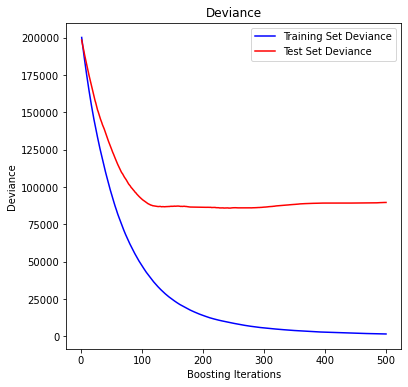

In [8]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.show()

## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

- Feature importances are provided by the fitted attribute `feature_importances_` 


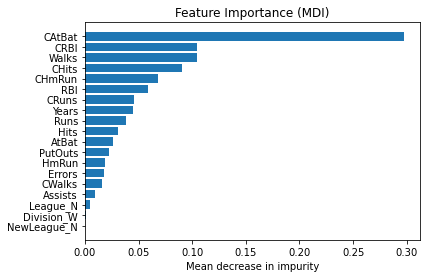

In [9]:
# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [10]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances = pd.Series(result.importances_mean, index=feature_names)

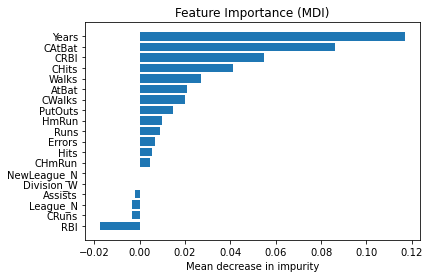

In [11]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

Text(0.5, 1.0, 'Permutation Importance (test set)')

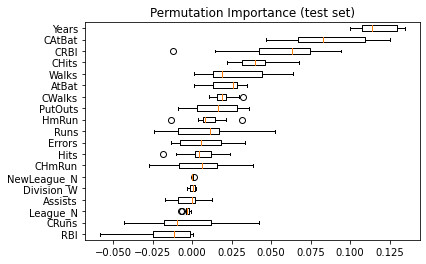

In [12]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

- We observe that the same features are detected as most important using both methods (e.g., `CAtBat`, `CRBI`, `CHits`, `Walks`, `Years`). Although the relative importances vary (especially for feature `Years`).